In [40]:
import os
import glob
import numpy as np
import pandas as pd
from obspy import UTCDateTime, read, Stream
import matplotlib.pyplot as plt

project_dir = f'{os.getcwd()}/..'
pn_dir = f'{project_dir}/results/phasenet_diting_others/phasenet_files'
waveform_dir = f'{project_dir}/data/eq_data/2_waveforms/mseed'

pn_picks = f"{pn_dir}/PN_w_stdist_varified_921.csv"
# allpick_file = f'{ppick_dir}/ALL_PICKS_POL_921.csv'

In [41]:
mseed_list = [f for f in os.listdir(waveform_dir) if f.endswith('.mseed')]
print(mseed_list)
# read the eq catalog
eq_cat_df = pd.read_csv(f'{project_dir}/data/eq_data/1_eq_catalogs/usgs_eq_above_slab2_all.csv')

# read the ppick file (includes phasenet, diting, pyrocko picks)
pol_df = pd.read_csv(pn_picks, parse_dates=['phase_time'])

print(pol_df.shape)
pol_df.head()

['nc40215740.mseed', 'nc72110581.mseed', 'nc73076250.mseed', 'nc72895731.mseed', 'nc71259711.mseed', 'nc71407421.mseed', 'nc51203864.mseed', 'nc71993336.mseed', 'nc72415885.mseed', 'nc51197189.mseed', 'nc73833291.mseed', 'nc71480081.mseed', 'nc72109965.mseed', 'nc73178780.mseed', 'nc72847541.mseed', 'nc71360785.mseed', 'nc73911986.mseed', 'nc71990966.mseed', 'nc71488095.mseed', 'nc72154546.mseed', 'nc71616480.mseed', 'nc72641551.mseed', 'nc72187616.mseed', 'nc71541725.mseed', 'nc72390536.mseed', 'nc73684886.mseed', 'nc73138650.mseed', 'nc72791686.mseed', 'nc73617261.mseed', 'nc73350095.mseed', 'nc73828311.mseed', 'nc72095756.mseed', 'nc73739276.mseed', 'nc72284206.mseed', 'nc73751651.mseed', 'nc72074151.mseed', 'nc73033931.mseed', 'nc73783916.mseed', 'nc73924166.mseed', 'nc71546480.mseed', 'nc73571131.mseed', 'nc72680411.mseed', 'nc51222070.mseed', 'nc73812326.mseed', 'nc71587015.mseed', 'nc40232592.mseed', 'nc71566861.mseed', 'nc71487220.mseed', 'nc73934141.mseed', 'nc72946846.mseed',

,station_id,begin_time,phase_index,phase_time,phase_score,phase_type,file_name,phase_amplitude,phase_amp,sta_dist_km
0,XQ.ME31.01.BH,2008-04-04T17:10:56.150,3415,2008-04-04 17:11:30.300,0.955,P,nc40214567.mseed,14003.805664,14003.805664,5.65
1,XQ.ME32.01.BH,2008-04-04T17:10:56.150,3462,2008-04-04 17:11:30.770,0.969,P,nc40214567.mseed,10884.021484,10884.021484,10.78
2,BK.JCC..HH,2008-04-04T17:10:56.150,3486,2008-04-04 17:11:31.010,0.975,P,nc40214567.mseed,4026.403564,4026.403564,18.23
3,XQ.ME33.01.BH,2008-04-04T17:10:56.150,3599,2008-04-04 17:11:32.140,0.932,P,nc40214567.mseed,5679.313965,5679.313965,23.61
4,XQ.ME35.01.BH,2008-04-04T17:10:56.150,3731,2008-04-04 17:11:33.460,0.949,P,nc40214567.mseed,5652.571289,5652.571289,25.94


In [42]:
ev_idx = np.random.randint(0, len(mseed_list))
sel_ev = mseed_list[ev_idx]
sel_ev = 'nc72390536.mseed'

In [43]:
event_df = pol_df[pol_df['file_name'] == sel_ev]
mag = eq_cat_df.loc[eq_cat_df['id'] == sel_ev.split('.')[0], 'mag'].values[0]
st = read(f"{waveform_dir}/{sel_ev}")

print(mag, len(st), sel_ev, ev_idx)

2.18 144 nc72390536.mseed 533


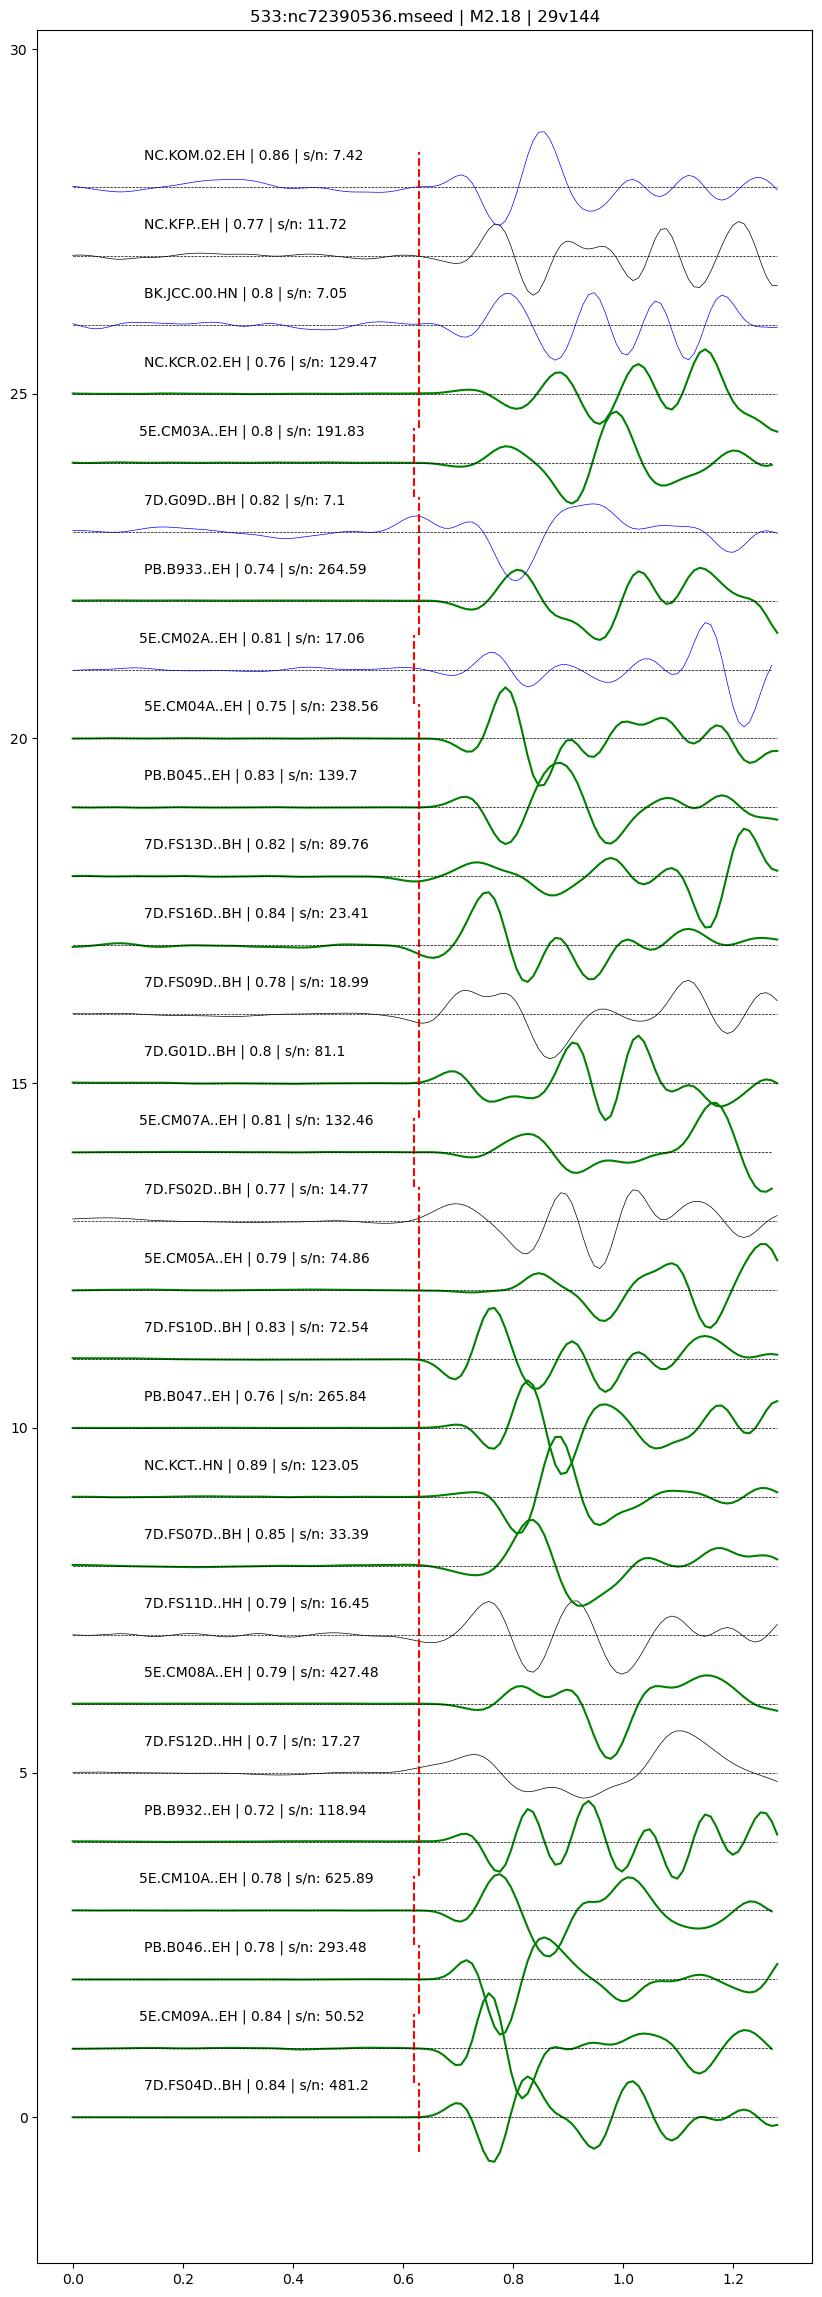

In [44]:
if os.path.exists(f'{pn_dir}/PN_w_stdist_varified_921_goodtrace.csv'):
    pol_df_goodtrace = pd.read_csv(f'{pn_dir}/PN_w_stdist_varified_921_goodtrace.csv') 
else:
    pol_df_goodtrace = pd.DataFrame(columns=pol_df.columns)

# calculate signal to noise ratio
fig, ax = plt.subplots(1, 1, figsize=(10, event_df.shape[0]))
iplt = 0

for i, row in event_df.iterrows():
    phase_time = UTCDateTime(pd.to_datetime(str(row.phase_time)))
    ist = st.select(id=f"{row.station_id}Z")
    if len(ist) == 0:
        continue
    tr = ist[0].copy()

    tr.detrend('demean')
    tr.taper(0.001)
    tr.filter('bandpass', freqmin=1.5, freqmax=10)

    # normalize the trace
    # tr.data = tr.data / np.max(np.abs(tr.data))

    ##### define signal window and noise window as 10s before the phase time and 10s after the phase time
    signal_window = [phase_time, phase_time+0.5]
    noise_window = [phase_time-0.6, phase_time-0.1]

    signal = tr.slice(starttime=signal_window[0], endtime=signal_window[1])
    noise = tr.slice(starttime=noise_window[0], endtime=noise_window[1])

    sigmax = np.max(np.abs(signal.data))
    noisemax = np.max(np.abs(noise.data))

    snr = (sigmax/noisemax).round(2)

    ##### std
    # how many samples within 1 std
    tr2 = tr.slice(starttime=phase_time-1, endtime=phase_time+1)
    std = np.std(tr2.data)
    mean = np.mean(tr2.data)
    nstd = (np.sum(np.abs(tr2.data-mean) < std)/len(tr2.data)).round(2)

    #### for plotting
    tr = tr.slice(starttime=phase_time-.63, endtime=phase_time+.64)
    pick_sec = np.round(phase_time - tr.stats.starttime, 2) #- 0.1

    # normalize the trace
    tr.data = tr.data / np.max(np.abs(tr.data))

    # varible zoom
    zoom = 2
    spread = np.std(tr.data)          
    vzoom = zoom/np.round(spread, 2)/10 if spread.round(2) != 0 else zoom

    if len(tr) == 0:
        continue
    
    # time axis
    xtimes = np.linspace(0, len(tr.data)/tr.stats.sampling_rate, len(tr.data))

    # plot
    if snr >= 20 and nstd >= 0.7:
        ax.plot(xtimes, tr.data * vzoom + iplt, color='g')
        if pol_df_goodtrace.shape[0] == 0:
            pol_df_goodtrace = row.to_frame().T
        else:
            pol_df_goodtrace = pd.concat([pol_df_goodtrace, row.to_frame().T])
    elif 5 <= snr < 20 and nstd >= 0.8:
        ax.plot(xtimes, tr.data * vzoom + iplt, color='b', lw=0.5)
    else:
        ax.plot(xtimes, tr.data * vzoom + iplt, color='k', lw=0.5)

    ax.plot([pick_sec, pick_sec], [iplt - 0.5, iplt+0.5], color='r', linestyle='--')
    # ax.text(pick_sec-.5, iplt+.2, f"{row.pyrocko_polarity}/{row.diting_polarity}-{row.diting_sharpness}|{row.phase_score} | {row.sta_dist_km}", color='k')
    ax.text(pick_sec-0.5, iplt+.4, f"{row.station_id} | {nstd} | s/n: {snr}", color='k')
    # horizontal line
    ax.plot([0, len(tr.data)/tr.stats.sampling_rate], [iplt, iplt], color='k', linestyle='--', lw=0.5)
    iplt += 1

    # break

plt.title(f'{ev_idx}:{sel_ev} | M{mag} | {iplt}v{len(st)}')
plt.show()

Text(0, 50, '634 events with 8 or more traces')

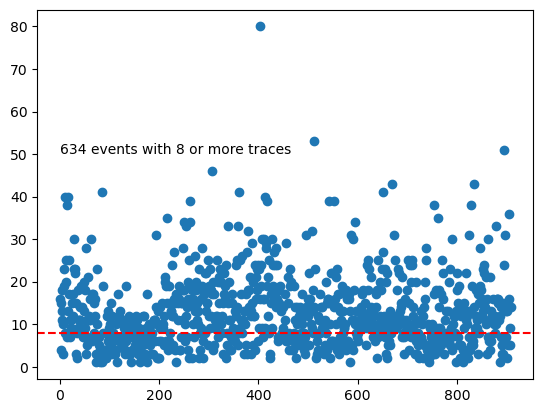

In [45]:
# plot groupby file_name
fig, ax = plt.subplots()
trcount = pol_df_goodtrace.groupby('file_name').count().station_id.to_list()
ax.scatter(range(len(trcount)), trcount)
ax.axhline(y=8, color='r', linestyle='--')
ax.text(0, 50, f'{len([i for i in trcount if i >= 8])} events with 8 or more traces', color='k')

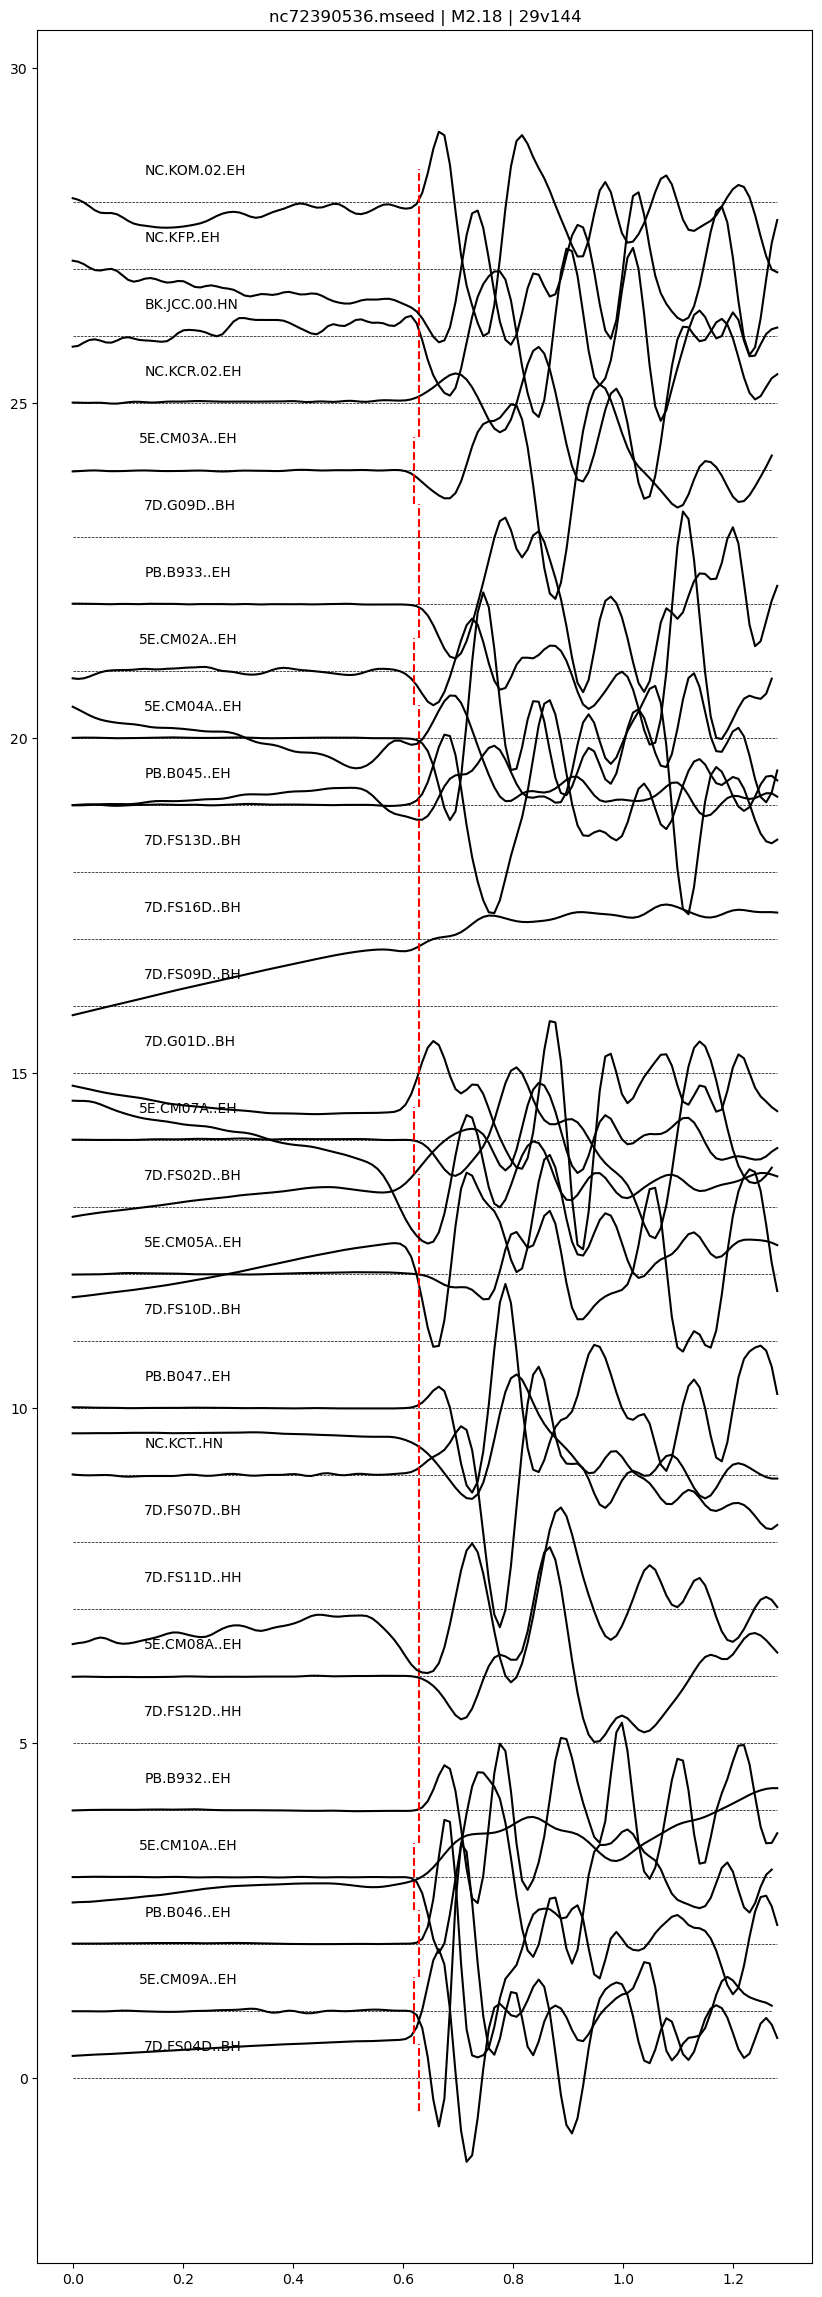

In [46]:
fig, ax = plt.subplots(1, 1, figsize=(10, event_df.shape[0]))

iplt = 0
for i, row in event_df.iterrows():
    phase_time = UTCDateTime(pd.to_datetime(str(row.phase_time)))
    ist = st.select(id=f"{row.station_id}Z")
    
    if len(ist) == 0:
        continue
    tr = ist[0].copy()
    
    tr.detrend('demean')
    try:
        tr.detrend('linear')
    except:
        tr.detrend('constant')
    
    try:
        tr.taper(0.001)
        # tr.filter('bandpass', freqmin=1.5, freqmax=10)
    except:
        pass

    tr = tr.slice(starttime=phase_time-.63, endtime=phase_time+.64)

    pick_sec = np.round(phase_time - tr.stats.starttime, 2) #- 0.1

    # normalize the trace
    tr.data = tr.data / np.max(np.abs(tr.data))

    # varible zoom
    zoom = 5
    spread = np.std(tr.data)          
    vzoom = zoom/np.round(spread, 2)/10 if spread != 0 else zoom

    if len(tr) == 0:
        continue

    xtimes = np.linspace(0, len(tr.data)/tr.stats.sampling_rate, len(tr.data))

    ax.plot(xtimes, tr.data * vzoom + iplt, color='k')
    ax.plot([pick_sec, pick_sec], [iplt - 0.5, iplt+0.5], color='r', linestyle='--')
    # ax.text(pick_sec-.5, iplt+.2, f"{row.pyrocko_polarity}/{row.diting_polarity}-{row.diting_sharpness}|{row.phase_score} | {row.sta_dist_km}", color='k')
    ax.text(pick_sec-0.5, iplt+.4, f"{row.station_id}", color='k')
    # horizontal line
    ax.plot([0, len(tr.data)/tr.stats.sampling_rate], [iplt, iplt], color='k', linestyle='--', lw=0.5)
    iplt += 1

    # break

plt.title(f'{sel_ev} | M{mag} | {iplt}v{len(st)}')
# flip the y-axis
# plt.gca().invert_yaxis()
plt.show()
